In [1]:
from pathlib import Path
files = sorted(Path("data/raw/net").glob("*"))
len(files), files[:5]

(17,
 [WindowsPath('data/raw/net/https_ajax_googleapis_com_ajax_libs_jquery_1_8_3_jquery_min_js_055d28.bin'),
  WindowsPath('data/raw/net/https_ajax_googleapis_com_ajax_libs_jqueryui_1_9_1_jquery_ui_min_js_bed17e.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_exo_400_600_800_26bc18.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_open_sans_400italic_300_400_600_700_b0e05c.bin'),
  WindowsPath('data/raw/net/https_fonts_googleapis_com_css_family_open_sans_condensed_700_7fb311.bin')])

In [2]:
import json, pandas as pd, re
from pathlib import Path

netdir = Path("data/raw/net")

# 2.a JSON "xmlproxy" (ya viene como .json)
f_xmlproxy = next(netdir.glob("*xmlproxy*.json"), None)

# 2.b "getgenericvaluemaxminwithnull4" (probablemente JSON pero .bin)
f_get = next(netdir.glob("*getgenericvaluemaxminwithnull4*.bin"), None)

f_xmlproxy, f_get

(WindowsPath('data/raw/net/https_www_clal_it_clal20_cc_atomicharts_server_xmlproxy_php_url_en_statistiche_quadro_d_ricavi_export_prod_php_p_eu_27_26c_04041002_26mov_e__35b3b0.json'),
 WindowsPath('data/raw/net/https_www_clal_it_clal20_grafici_getgenericvaluemaxminwithnull4_php_field_price_product_prezzo_whey_avg_m_y_min_2020_01_01_order_date_spline_0dce85.bin'))

In [3]:
import io

def load_maybe_json(path: Path):
    """Intenta cargar como JSON; si falla, intenta decodificar texto y extraer JSON embebido."""
    b = path.read_bytes()
    # prueba json directo
    try:
        return json.loads(b)
    except Exception:
        pass
    # intenta como texto
    try:
        s = b.decode("utf-8", errors="ignore")
        # a veces devuelven JSON ya "limpio"
        s = s.strip()
        # extrae el primer {} o [] grande
        m = re.search(r"(\{.*\}|\[.*\])", s, flags=re.S)
        if m:
            return json.loads(m.group(1))
    except Exception:
        pass
    return None

def to_df_from_series(obj):
    """
    Convierte diferentes formatos comunes a un DataFrame con columnas: date, price.
    Soporta:
    - Highcharts: data = [[ts_ms, y], ...] o [{x:..., y:...}]
    - Objetos con claves 'date'/'value' o 'price'
    - Respuestas tipo { series: [{name, data: ...}], xAxis:{categories: ...} }
    """
    # Caso lista de pares/objs
    if isinstance(obj, list):
        # [[x,y], ...]
        if obj and isinstance(obj[0], list) and len(obj[0]) >= 2:
            df = pd.DataFrame(obj, columns=["x","y"])
        # [{"x":..,"y":..}, ...]
        elif obj and isinstance(obj[0], dict) and {"x","y"} <= set(obj[0].keys()):
            df = pd.DataFrame(obj)[["x","y"]]
        # [{"date":..,"value":..}] o [{"date":..,"price":..}]
        elif obj and isinstance(obj[0], dict) and ("date" in obj[0]) and (("value" in obj[0]) or ("price" in obj[0])):
            df = pd.DataFrame(obj)
            df["y"] = df.pop("value") if "value" in df.columns else df.pop("price")
            df["x"] = pd.to_datetime(df.pop("date"), errors="coerce")
        else:
            return pd.DataFrame()
    elif isinstance(obj, dict):
        # Estructura con series estilo Highcharts
        if "series" in obj and isinstance(obj["series"], list):
            rows = []
            cats = obj.get("xAxis", {}).get("categories") if isinstance(obj.get("xAxis"), dict) else None
            for s in obj["series"]:
                data = s.get("data", [])
                for i, d in enumerate(data):
                    if isinstance(d, list) and len(d) >= 2:
                        rows.append({"x": d[0], "y": d[1]})
                    elif isinstance(d, dict):
                        rows.append({"x": d.get("x", i), "y": d.get("y")})
                    elif isinstance(d, (int, float)) and cats:
                        rows.append({"x": cats[i] if i < len(cats) else None, "y": d})
            return pd.DataFrame(rows)
        # arrays directamente en claves conocidas
        for k in ("data","values","points"):
            if k in obj and isinstance(obj[k], list):
                return to_df_from_series(obj[k])
        return pd.DataFrame()
    else:
        return pd.DataFrame()

    return df

def normalize_df(df):
    if df.empty: 
        return df
    # intentar convertir x a fecha
    if pd.api.types.is_numeric_dtype(df["x"]):
        # ts en ms?
        maybe_ms = df["x"].astype("float", errors="ignore")
        # heurística: > 10^10 ~ ms epoch
        try:
            dates = pd.to_datetime(maybe_ms, unit="ms", errors="coerce")
            if dates.notna().sum() >= len(df) * 0.5:
                df["date"] = dates.dt.date
            else:
                df["date"] = pd.to_datetime(df["x"], errors="coerce").dt.date
        except Exception:
            df["date"] = pd.to_datetime(df["x"], errors="coerce").dt.date
    else:
        df["date"] = pd.to_datetime(df["x"], errors="coerce").dt.date
    df = df.rename(columns={"y":"price"})
    df = df.dropna(subset=["date","price"])
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna(subset=["price"])
    return df[["date","price"]].sort_values("date")

In [4]:
frames = []

if f_xmlproxy:
    obj = load_maybe_json(f_xmlproxy)
    df1 = normalize_df(to_df_from_series(obj)) if obj is not None else pd.DataFrame()
    if not df1.empty:
        df1["spec"] = "WPC – xmlproxy"
        frames.append(df1)

if f_get:
    obj = load_maybe_json(f_get)
    df2 = normalize_df(to_df_from_series(obj)) if obj is not None else pd.DataFrame()
    if not df2.empty:
        df2["spec"] = "WPC – getgeneric"
        frames.append(df2)

len(frames), [len(x) for x in frames]

(0, [])

In [5]:
if frames:
    out = pd.concat(frames, ignore_index=True)
    out.insert(0, "commodity", "WPC")
    out.insert(1, "geography", "World")
    out["unit"] = "unknown"  # luego la detectamos desde el eje/leyenda si está en el JSON
    out["source_url"] = "https://www.clal.it/en/index.php?section=demi"
    out = out[["commodity","geography","spec","date","price","unit","source_url"]]
    out.to_csv("data/clal_powders_prices.csv", index=False)
    out.head()
else:
    print("No pude reconstruir series. Muéstrame el contenido de alguno de los .json/.bin para ajustar el parser.")

No pude reconstruir series. Muéstrame el contenido de alguno de los .json/.bin para ajustar el parser.


In [6]:
from pathlib import Path
import re, json
import pandas as pd
from collections import deque

netdir = Path("data/raw/net")
files = sorted(netdir.glob("*"))
print(f"Archivos detectados: {len(files)}")

# --- utilidades
def try_json_bytes(b: bytes):
    # 1) intento JSON directo
    try:
        return json.loads(b)
    except Exception:
        pass
    # 2) intento como texto + extraer primer bloque JSON grande {...} o [...]
    try:
        s = b.decode("utf-8", errors="ignore").strip()
        m = re.search(r"(\{.*\}|\[.*\])", s, flags=re.S)
        if m:
            return json.loads(m.group(1))
    except Exception:
        pass
    return None

def to_df_any(obj):
    """
    Intenta convertir cualquier estructura común a DataFrame con columnas x,y.
    Soporta:
    - [[x,y], ...]
    - [{'x':..., 'y':...}, ...]
    - {'series': [{'data': ...}], 'xAxis': {'categories': [...]}}
    - {'data': [...]} / {'values': [...]} / {'points': [...]}
    - [{'date': ..., 'value'| 'price': ...}, ...]
    Recorre recursivamente dicts/listas para encontrar arrays de puntos.
    """
    def df_from_list(L):
        if not L: return pd.DataFrame()
        a0 = L[0]
        if isinstance(a0, list) and len(a0) >= 2:
            return pd.DataFrame(L, columns=["x","y"])[["x","y"]]
        if isinstance(a0, dict):
            if {"x","y"}.issubset(a0.keys()):
                return pd.DataFrame(L)[["x","y"]]
            if "date" in a0 and ("value" in a0 or "price" in a0):
                df = pd.DataFrame(L)
                df["x"] = pd.to_datetime(df.pop("date"), errors="coerce")
                df["y"] = pd.to_numeric(df.pop("value") if "value" in df.columns else df.pop("price"), errors="coerce")
                return df[["x","y"]]
        return pd.DataFrame()

    # 1) listas directas
    if isinstance(obj, list):
        df = df_from_list(obj)
        if not df.empty: return df

    # 2) dict estilo Highcharts
    if isinstance(obj, dict):
        # series/data
        if "series" in obj:
            cats = None
            xaxis = obj.get("xAxis")
            if isinstance(xaxis, dict) and isinstance(xaxis.get("categories"), list):
                cats = xaxis["categories"]
            rows = []
            for s in obj.get("series", []):
                data = s.get("data", [])
                if isinstance(data, list):
                    for i, d in enumerate(data):
                        if isinstance(d, list) and len(d) >= 2:
                            rows.append([d[0], d[1]])
                        elif isinstance(d, dict):
                            rows.append([d.get("x", i), d.get("y")])
                        elif isinstance(d, (int, float)) and cats:
                            rows.append([cats[i] if i < len(cats) else None, d])
            if rows:
                return pd.DataFrame(rows, columns=["x","y"])
        # arrays en claves conocidas
        for k in ("data","values","points","items","result"):
            if isinstance(obj.get(k), list):
                df = df_from_list(obj[k])
                if not df.empty: return df

        # 3) búsqueda recursiva
        q = deque([obj])
        while q:
            cur = q.popleft()
            if isinstance(cur, dict):
                for v in cur.values():
                    if isinstance(v, (dict, list)): q.append(v)
            elif isinstance(cur, list):
                df = df_from_list(cur)
                if not df.empty: return df
                for v in cur:
                    if isinstance(v, (dict, list)): q.append(v)

    return pd.DataFrame()

def normalize(df):
    if df.empty: return df
    # convertir x -> fecha
    if pd.api.types.is_numeric_dtype(df["x"]):
        # heurística: epoch ms (muy grande)
        try:
            d1 = pd.to_datetime(df["x"], unit="ms", errors="coerce")
        except Exception:
            d1 = pd.to_datetime(df["x"], errors="coerce")
        d2 = pd.to_datetime(df["x"], errors="coerce")
        dates = d1.where(d1.notna(), d2)
    else:
        dates = pd.to_datetime(df["x"], errors="coerce")
    df2 = pd.DataFrame({
        "date": dates.dt.date,
        "price": pd.to_numeric(df["y"], errors="coerce")
    }).dropna()
    return df2.sort_values("date")

# --- inspección/parseo masivo
parsed = []
report = []

for p in files:
    if not p.suffix.lower() in (".json", ".bin", ".csv"):
        continue
    b = p.read_bytes()
    obj = try_json_bytes(b)
    if obj is None:
        report.append((p.name, "no-json"))
        continue
    df = to_df_any(obj)
    if df.empty:
        report.append((p.name, "json-sin-formato-conocido"))
        continue
    df = normalize(df)
    if df.empty:
        report.append((p.name, "sin-fechas-o-precios-validos"))
        continue
    df["source_file"] = p.name
    parsed.append(df)
    report.append((p.name, f"OK {len(df)} filas"))

len(parsed), report[:10]

Archivos detectados: 17


(0,
 [('https_ajax_googleapis_com_ajax_libs_jquery_1_8_3_jquery_min_js_055d28.bin',
   'no-json'),
  ('https_ajax_googleapis_com_ajax_libs_jqueryui_1_9_1_jquery_ui_min_js_bed17e.bin',
   'no-json'),
  ('https_fonts_googleapis_com_css_family_exo_400_600_800_26bc18.bin',
   'no-json'),
  ('https_fonts_googleapis_com_css_family_open_sans_400italic_300_400_600_700_b0e05c.bin',
   'no-json'),
  ('https_fonts_googleapis_com_css_family_open_sans_condensed_700_7fb311.bin',
   'no-json'),
  ('https_www_clal_it_cc_atomicharts_js_atomicharts_js_8e356b.bin', 'no-json'),
  ('https_www_clal_it_cc_atomicharts_js_exporting_js_292b9a.bin', 'no-json'),
  ('https_www_clal_it_cc_atomicharts_js_highcharts_js_29958e.bin', 'no-json'),
  ('https_www_clal_it_clal20_cc_atomicharts_server_xmlproxy_php_url_en_statistiche_quadro_d_ricavi_export_prod_php_p_eu_27_26c_04041002_26mov_e__35b3b0.json',
   'json-sin-formato-conocido'),
  ('https_www_clal_it_clal20_grafici_getgenericvaluemaxminwithnull4_php_field_price_pr

In [2]:
from pathlib import Path
import re
import pandas as pd

# 1) Localiza el .bin con valores de WPC (ajusta si fuera otro nombre)
netdir = Path("data/raw/net")
bin_path = next(netdir.glob("*getgenericvaluemaxminwithnull4*prezzo_whey*/*.bin"), None)
if bin_path is None:
    # a veces no hay subcarpeta; probamos en el propio directorio
    bin_path = next(netdir.glob("*getgenericvaluemaxminwithnull4*prezzo_whey*.bin"))

text = bin_path.read_text(encoding="utf-8", errors="ignore")

# 2) Extrae la lista de valores
m_vals = re.search(r"values\s*=\s*([0-9\.,\s\-NaN]+)", text)
if not m_vals:
    raise ValueError("No se encontró 'values=' en el archivo.")

vals_raw = m_vals.group(1)
# normaliza y convierte
values = []
for x in re.split(r"[,\s]+", vals_raw.strip()):
    if x == "" or x.lower() == "nan":
        values.append(None)
    else:
        try:
            values.append(float(x))
        except:
            values.append(None)

# 3) Intenta extraer fechas explícitas si existen (dates= o labels= con ISO)
m_dates = re.search(r"dates\s*=\s*([0-9,\-\s]+)", text) or re.search(r"labels\s*=\s*([0-9,\-\s:TZ]+)", text)
dates = None
if m_dates:
    dates_raw = m_dates.group(1)
    # separa por coma o espacios
    parts = [p.strip() for p in re.split(r"[,\s]+", dates_raw.strip()) if p.strip()]
    # convierte a fecha
    dconv = pd.to_datetime(parts, errors="coerce")
    if dconv.notna().sum() >= len(values) * 0.5:  # heurística
        dates = dconv.dt.date.tolist()

# 4) Si no hay fechas, derivamos el start date de la propia ruta
if dates is None:
    # la ruta original de CLAL está embedida en el nombre del archivo; buscamos _min_YYYY_MM_DD_
    m_start = re.search(r"_min_(\d{4})_(\d{2})_(\d{2})_", bin_path.name)
    if not m_start:
        raise ValueError("No se pudo deducir start date desde el nombre del archivo.")
    y, mo, d = map(int, m_start.groups())
    start = pd.Timestamp(year=y, month=mo, day=d)
    # asumimos periodicidad mensual (CLAL usa mensual para series 'avg_m')
    freq = "MS"  # Month Start
    dates = pd.date_range(start=start, periods=len(values), freq=freq).date

# 5) Construye el DataFrame y limpia nulos
df = pd.DataFrame({"date": dates, "price": values})
df = df.dropna(subset=["price"])
df = df.sort_values("date")

# 6) Añade metadatos y guarda el CSV final
df.insert(0, "commodity", "WPC")
df.insert(1, "geography", "World")
df.insert(2, "spec", "WPC – avg (CLAL getgeneric)")
df["unit"] = "USD/Tons"  # el y-axis en tu JSON indicaba USD/Tons
df["source_url"] = "https://www.clal.it/en/index.php?section=demi"

out = df[["commodity","geography","spec","date","price","unit","source_url"]]
out.to_csv("data/clal_powders_prices.csv", index=False)
len(out), out.head()

(70,
   commodity geography                         spec        date    price  \
 0       WPC     World  WPC – avg (CLAL getgeneric)  2020-01-01  2206.29   
 1       WPC     World  WPC – avg (CLAL getgeneric)  2020-02-01  2235.64   
 2       WPC     World  WPC – avg (CLAL getgeneric)  2020-03-01  2237.70   
 3       WPC     World  WPC – avg (CLAL getgeneric)  2020-04-01  2223.92   
 4       WPC     World  WPC – avg (CLAL getgeneric)  2020-05-01  2119.76   
 
        unit                                     source_url  
 0  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 1  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 2  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 3  USD/Tons  https://www.clal.it/en/index.php?section=demi  
 4  USD/Tons  https://www.clal.it/en/index.php?section=demi  )

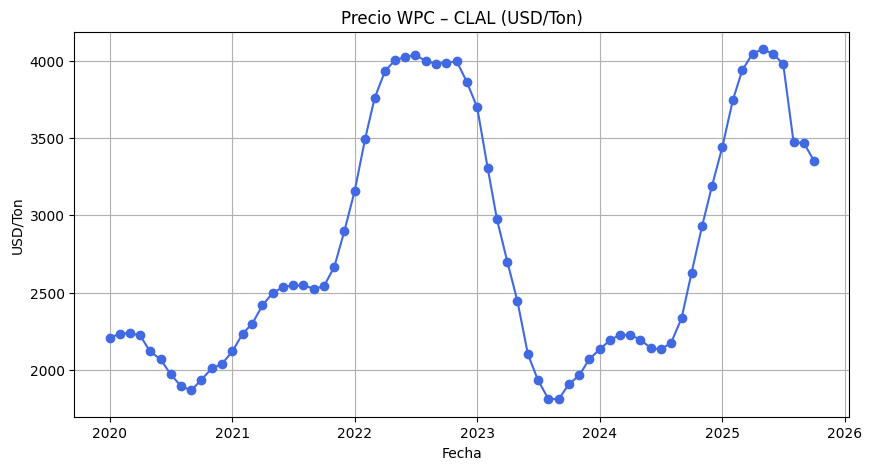

<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/clal_powders_prices.csv", parse_dates=["date"])

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["price"], marker="o", color="royalblue")
plt.title("Precio WPC – CLAL (USD/Ton)")
plt.xlabel("Fecha")
plt.ylabel("USD/Ton")
plt.grid(True)
plt.show()
plt.savefig("data/wpc_price_trend.png", dpi=150, bbox_inches="tight")